#### Computational Astrophysics Assignment 3

Hsin Fan D12244001

#### Poisson Equation in 2D

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from final_project_HF import Poisson2D
import time
import torch

In [8]:
def ref_func(x, y):
    return y*(1-y)*x**3

def source_term(x, y):
    return 6*x*y*(1-y)-2*x**3

In [9]:
N=128
poisson = Poisson2D(N=N)
x = poisson.x.cpu()  
BC = np.zeros((N+2, N+2))
BC[-1, 1:-1] = x.numpy() * (1 - x.numpy())  


source = source_term(x[:, None], x[None, :])

The figure below is what analytical solution looks like under a 128-by-128 grid.

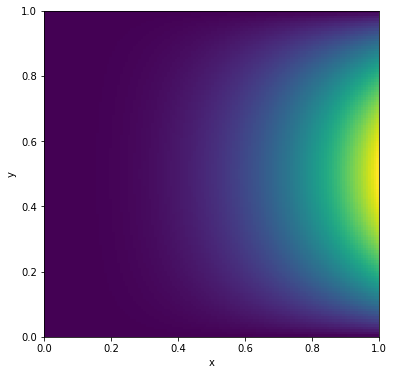

In [10]:
ref = ref_func(x[:, None], x[None, :])
fig = plt.figure(figsize=(6, 6))
fig.gca().pcolormesh(np.linspace(0, 1, N+1), np.linspace(0, 1, N+1), ref.T)
fig.gca().set_xlabel("x")
fig.gca().set_ylabel("y")
plt.show()

In [11]:
schemes = ["CG", "Gauss-Seidel", "SOR"]
resolution = np.array([2,4,8,16])
error_all = []
iters_all = []
wall_time_all = []

for scheme in schemes:
    error = []
    iters = []
    wall_time = []

    for N in resolution:
        poisson = Poisson2D(N=N, device='cuda')

        x = poisson.x.cpu().numpy()  
        ref = ref_func(x[:, None], x[None, :])        
        BC = np.zeros((N+2, N+2))
        BC[-1, 1:-1] = x * (1 - x)  
        source = source_term(x[:, None], x[None, :])

        if scheme == "SOR":
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=torch.tensor(BC, device='cuda'), source=torch.tensor(source, device='cuda'), w=1.6905, terminate=1e-12)
            t2 = time.time()
        else:
            t1 = time.time()
            poisson.run(scheme=scheme, steps=None, BC=torch.tensor(BC, device='cuda'), source=torch.tensor(source, device='cuda'), terminate=1e-12)
            t2 = time.time()

        error.append(np.abs(poisson.u.cpu().numpy()[1:-1, 1:-1] - ref).sum() / N**2)
        print(error)
        iters.append(poisson.steps)
        wall_time.append(t2 - t1)

    error_all.append(error)
    iters_all.append(iters)
    wall_time_all.append(wall_time)

[0.009765624011763306]
[0.009765624011763306, 0.008056641101429105]
[0.009765624011763306, 0.008056641101429105, 0.005581531078768262]
[0.009765624011763306, 0.008056641101429105, 0.005581531078768262, 0.003143267690368283]
[0.009765625000319744]
[0.009765625000319744, 0.008056640625274551]
[0.009765625000319744, 0.008056640625274551, 0.005581530988064161]
[0.009765625000319744, 0.008056640625274551, 0.005581530988064161, 0.0031432680159070897]
[0.009765625000029388]
[0.009765625000029388, 0.008056640625244079]
[0.009765625000029388, 0.008056640625244079, 0.005581530986694127]
[0.009765625000029388, 0.008056640625244079, 0.005581530986694127, 0.003143268008693102]


a. and c. Compare the scaling between spatial resolutions and errors, iterations required and wall times required.

The scaling between resolutions and errors is expected to be (inversely) second-order. However, as shown in the first figure below, I get a scaling of (inversely) first order.

As shown in the second figure below, the scaling between resolutions and iterations required for convergence is close to second order.

As shown in the third figure below, the scaling between resolutions and wall-time required for convergence is close to fourth order.

C:\Users\user\AppData\Local\Temp\ipykernel_94092\3646078301.py:16: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig2.gca().set_yscale("log", base=10)
C:\Users\user\AppData\Local\Temp\ipykernel_94092\3646078301.py:15: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  fig2.gca().scatter(resolution, iter, label=schemes[i])


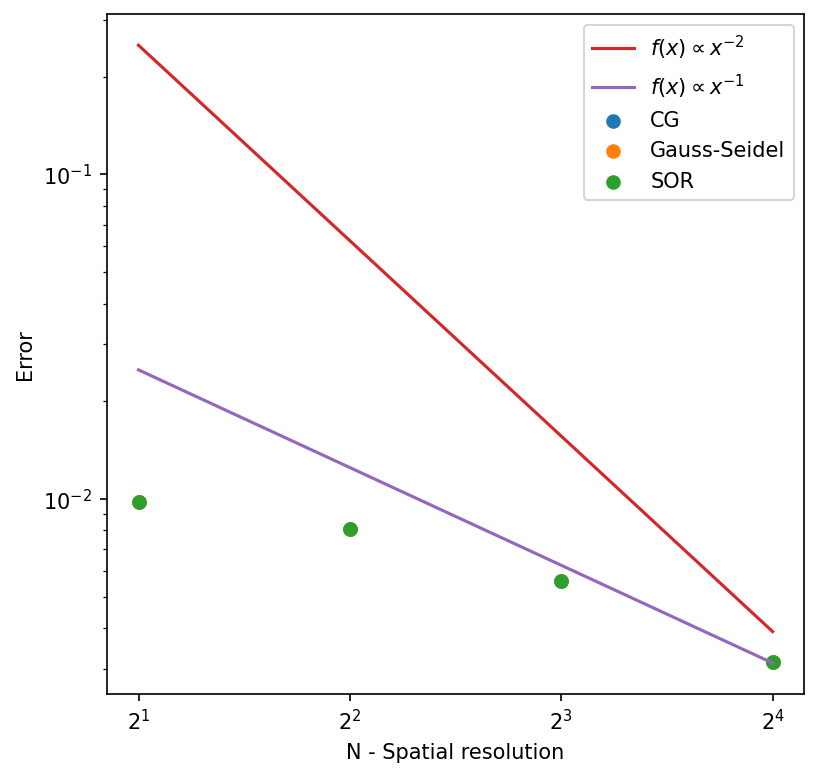

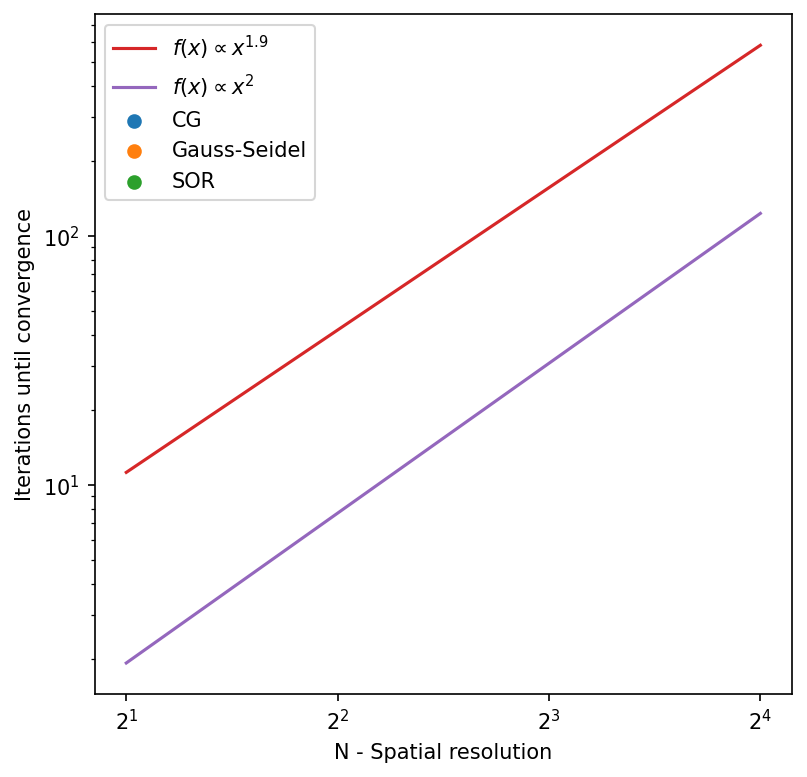

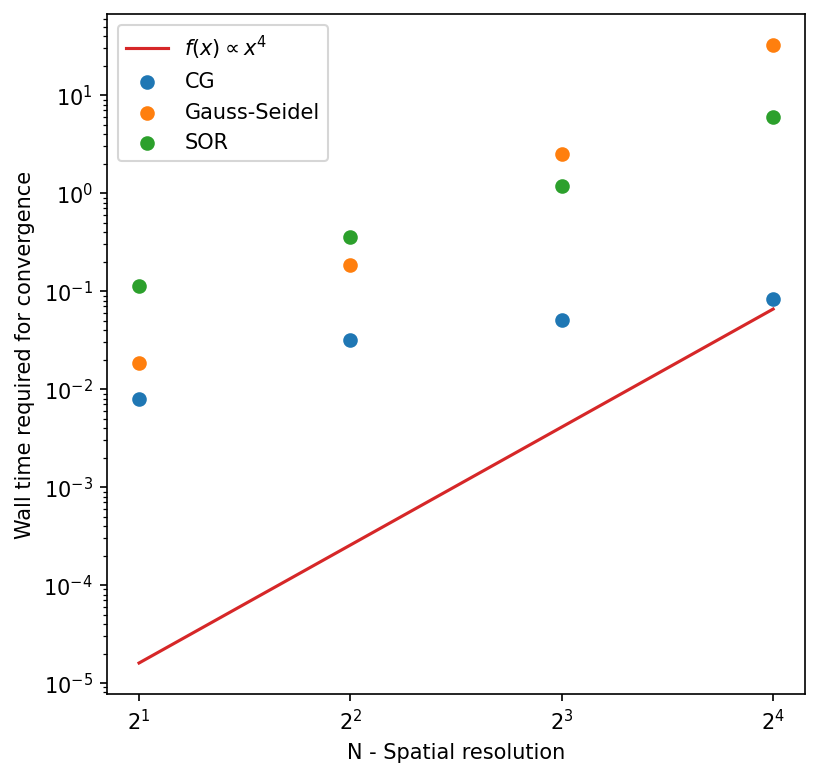

In [12]:
fig1, axes1 = plt.subplots(figsize=(6, 6), dpi=150)
fig2, axes2 = plt.subplots(figsize=(6, 6), dpi=150)
fig3, axes3 = plt.subplots(figsize=(6, 6), dpi=150)

for i, err in enumerate(error_all):
    fig1.gca().scatter(resolution, err, label=schemes[i])
    fig1.gca().set_yscale("log", base=10)
    fig1.gca().set_xscale("log", base=2)
    fig1.gca().set_xlabel("N - Spatial resolution")
    fig1.gca().set_ylabel("Error")
    
    

for i, iter in enumerate(iters_all):
    fig2.gca().scatter(resolution, iter, label=schemes[i])
    fig2.gca().set_yscale("log", base=10)
    fig2.gca().set_xscale("log", base=2)
    fig2.gca().set_xlabel("N - Spatial resolution")
    fig2.gca().set_ylabel("Iterations until convergence")
    
    

for i, _wall_time in enumerate(wall_time_all):
    fig3.gca().scatter(resolution, _wall_time, label=schemes[i])
    fig3.gca().set_yscale("log", base=10)
    fig3.gca().set_xscale("log", base=2)
    fig3.gca().set_xlabel("N - Spatial resolution")
    fig3.gca().set_ylabel("Wall time required for convergence")
    
    
    

res = np.linspace(resolution[0], resolution[-1], 1000)
fig1.gca().plot(res, res**(-2), label=r"$f(x) \propto x^{-2}$", c='C3')
fig1.gca().plot(res, 5e-2*res**(-1), label=r"$f(x) \propto x^{-1}$", c='C4')
fig2.gca().plot(res, 3*res**(1.9), label=r"$f(x) \propto x^{1.9}$", c='C3')
fig2.gca().plot(res, 0.48*res**(2), label=r"$f(x) \propto x^{2}$", c='C4')
fig3.gca().plot(res, 1e-6*res**(4), label=r"$f(x) \propto x^{4}$", c='C3')
fig1.gca().legend()
fig2.gca().legend()
fig3.gca().legend()

plt.show()

Given that the overrelaxation parameter should be between 1 and 2, exclusive. The cells below are used to determine the optimal overrelaxation parameter. I search w in the domain 1.0001 and 1.99

In [13]:
_w = np.linspace(1.0001, 1.99, 1000, endpoint=False)
iterations = []

for w in _w:  
    poisson = Poisson2D(N=16)

    #print(w)
    x = poisson.x
    #ref = ref_func(x[:, None], x[None, :])        
    BC = np.zeros((16+2, 16+2))
    BC[-1, 1:-1] = x*(1-x)
    source = source_term(x[:, None], x[None, :])

    poisson.run(scheme="SOR", steps=None, BC=BC, source=source, print_err=False, w=w, terminate=1e-13)

    iterations.append(poisson.steps)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
fig4, axes4 = plt.subplots(figsize=(6, 6), dpi=150)
fig4.gca().scatter(_w, iterations)
fig4.gca().set_yscale("log", base=10)
fig4.gca().set_xlabel("w")
fig4.gca().set_ylabel("Iterations until convergence")
plt.show()

In [ ]:
index_min = np.argmin(np.array(iterations))

_w2 = np.linspace(_w[index_min-1], _w[index_min+1], 1000, endpoint=False)
iterations2 = []

for w in _w2:  
    poisson = Poisson2D(N=16)

    x = poisson.x
    #ref = ref_func(x[:, None], x[None, :])        
    BC = np.zeros((16+2, 16+2))
    BC[-1, 1:-1] = x*(1-x)
    source = source_term(x[:, None], x[None, :])

    poisson.run(scheme="SOR", steps=None, BC=BC, source=source, print_err=False, w=w, terminate=1e-13)

    iterations2.append(poisson.steps)

In [ ]:
fig5, axes5 = plt.subplots(figsize=(6, 6), dpi=150)
fig5.gca().scatter(_w2, iterations2)
fig5.gca().set_xlabel("w")
fig5.gca().set_ylabel("Iterations until converge")

b. The cell below retrieves the interval of overrelaxation parameter, w, where the required number of iterations until convergence is the lowest. The optimal w for this problem under a spatial resolution of 16 by 16 is between 1.690159 and 1.690925.

In [ ]:
print(_w2[np.argmin(np.array(iterations2))])
print(_w2[np.argmin(np.array(iterations2)[::-1])])